# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [27]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [28]:
# Your work here.

### #1 Is the distribution of body temperatures normal?

In [29]:
df.head(5)

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


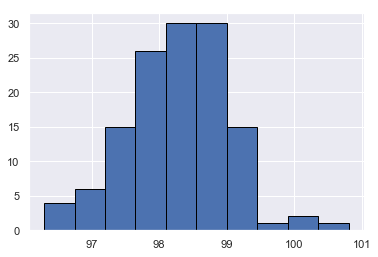

In [30]:
# import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# set default Seaborn style
sns.set()

# plot histogram of temperature
_ = plt.hist(df['temperature'], edgecolor='black')

plt.show()

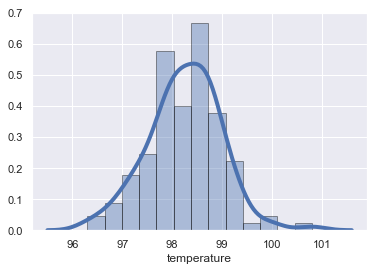

In [31]:
# seaborn histogram
sns.distplot(df['temperature'], hist=True, kde=True, 
             hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4})

From the first histogram, it looks approximately normal but I decided to further test it with the Seaborn histogram plot (see above). 

With this distplot, we are able to create a both a histogram and a density plot, which is a smoothed, continuous version of the histogram estimated from the data. From the shape, we are able to comfirm that the curve appears to be approximately normal. 

To take it one step further, we will use an Cumulative Disribution Function to assess the temperatures 

In [32]:
import numpy as np
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [33]:
mean_temp = np.mean(df['temperature'])
std_temp = np.std(df['temperature'])

# Sample out of a normal distribution with mean and std
temp_samples = np.random.normal(mean_temp, std_temp, 10000)

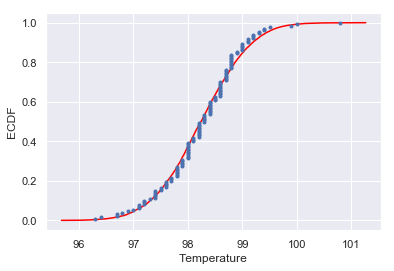

In [34]:
x_theor, y_theor = ecdf(temp_samples)
x, y = ecdf(df['temperature'])

plt.plot(x_theor, y_theor, color='red')
plt.plot(x, y, marker='.', linestyle='none')

_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')

plt.show()

So what did we just do? 

First, we took the mean and standard deviation of the temperature data and then created a theoretical distribution from 10,000 samples. 

Next, we plotted a theoretical CDF (cumulative distribution function) and an ECDF of the data. From the figure above, the data points fall in line nicely with the theoretical CDF, suggesting that temperature is indeed normally distributed.  

## #2 Is the sample size large? Are the observations independent?

In [35]:
# call shape, which returns total number of rows and columns
df.shape[0]

130

There are 130 samples in this dataset.

The Central Limit Theorem states the following:
- the sample mean follows approximately the normal distribution with mean µ and standard deviation √σ/n, where µ and σ are the mean and standard deviation of the population from where the sample was selected.
-  The sample size n has to be large (usually n ≥ 30) if the population from where the sample is taken is nonnormal. If the population follows the normal distribution then the sample size n can be either small or large.
(http://www.stat.ucla.edu/~nchristo/introeconometrics/introecon_central_limit_theorem.pdf)

Since our sample size is greater than 30, we can assume that the sample size is large enough. 

With the assumption that this data set was the result of a reasonably random selection process, and that 130 is less than 10% of the population, it can be said that the observations are independent of each other. 

## #3 Is the true population mean really 98.6 degrees F?

In [36]:
# First, try a bootstrap hypothesis test

#### Step 1: State null and alternative hypotheses
- Null Hypothesis: The true mean temperature for the population is 98.6 degrees fahrenheit
- Alternative Hypothesis: The true mean temperature for the population is LESS THAN 98.6 degrees fahrenheit

#### Step 2: Set the significance level
- alpha or α = 5% (0.05) 
- will be a 95% confidence interval

#### Step 3: Choose test statistic
- mean temperature

In [37]:
# Step 4: Find the observed value of the test statistic (i.e. mean temperature from the original data)
mean_temp = np.mean(df['temperature'])
print('The mean temperature of the original sample is', mean_temp)

The mean temperature of the original sample is 98.24923076923078


#### The p-value

- Now we need the p-value, but to do this we need to know the sampling distribution of our test statstic when the null hypothesis (i.e. the true mean temperature for the population is 98.6 degrees fahrenheit) is true. 
- From the previous questions, we know the distribution is approximately normal so the approach will be to perform a simulation under conditions in which we know the null hypothesis to be true
- We'll use our data to represent the population, but first we need to shift it over so the mean is really 98.6 degrees Fahrenheit

In [38]:
# translate the observed temperature to 98.6 degrees Fahrenheit 
translated_temp = df['temperature'] - np.mean(df['temperature']) + 98.60

Now we're going to take 130 observations at random (because that's the size of the original sample). We calculate the mean of that random sample (which should be close to 98.6). We'll then save the mean and repeat this process 10,000 more times. 

After this, it'll give a good idea of what sort of sample averages we should expect when the true mean is 98.6.

In [39]:
# function to draw random sample, of size that is equal to the length of the data (which is 130 in this case)
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# function to store means of the bootstrap replicates, with default size of 1 (in our case this will be 10,000)
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [40]:
# store bootstrap replicates in variable bs_translate_replicates
bs_translate_replicates = draw_bs_reps(translated_temp, np.mean, 10000)
np.mean(bs_translate_replicates)

98.59931907692307

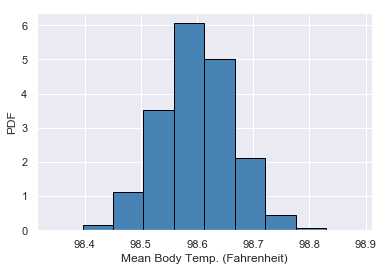

In [41]:
# plot replicates to show that it's distribution is approximately normal
_ = plt.hist(bs_translate_replicates, density=True, color='steelblue', edgecolor='black')
_ = plt.xlabel('Mean Body Temp. (Fahrenheit)')
_ = plt.ylabel('PDF')
plt.show()

As you can see, the histogram of the bootstrap replicates is approximately normal, the only difference being that it is shifted over so that it is centered at 98.6 instead of 98.24.

In this situation, is it appropriate to use the 𝑡 or 𝑧 statistic? 
Answer: The general rule of thumb for when to use a t-score is when your sample (1) has a sample size below 30 and (2) has an unknown population standard deviation. 

While our sample size is greater than 30, we unfortunately do not know the standard deviation of the population...

<img src='t-z-score.png'>

The above graph continues with that general rule of thumn, which in this case will lead us to use the t-score. Also, in real life it is more common to use the t-dsitribution because we usually don't know sigma.

However...there is small caveat. Remember how our sample was greater than 30?

"When a sample has more than 30 observations, the normal distribution can be used in place of the t-distribution." (Meier et.al, p. 191)

This is because if you have a larger sample (n >= 30) the t and z-distribution look pretty much the same, which is why they are virtually identical in this case and you'll get the same result. 

#### T-Score

t = (X – μ) / [ s/√(n) ]

- where s is the standard deviation of the sample

In our case...
- X ≈ 98.24 (mean from the original example)
- μ = 98.6

But we still need to determine the standard deviation of the (translated) sample

In [42]:
std_translated_temperature = np.std(bs_translate_replicates)
print('The standard deviation of the translated bootstrap replicates is', std_translated_temperature)

The standard deviation of the translated bootstrap replicates is 0.06351047633358094


In [43]:
bs_t_value = ((np.mean(df['temperature']) - np.mean(bs_translate_replicates)) / 
              (std_translated_temperature / np.sqrt(130)))
print('The t-value (or score) for the bootstrap sample is', bs_t_value)

The t-value (or score) for the bootstrap sample is -62.84980181045151


From the t-score, things aren't looking too good. To confirm, we'll calculate the p-value and compare that to the significane level of 5% (i.e. 0.05). If the p-value is lower than the signficance level, than we can reject the null hypthesis that the true mean temperature is 98.6 degrees. 

In [44]:
# Compute fraction of replicates that are less than observered body temperature
p = np.sum(bs_translate_replicates <= np.mean(df['temperature'])) / 10000
print('p = ', p)

p =  0.0


As we can see our p-value is so low that it is essentially 0. Since 0 < 0.05 (i.e. our p-value < significance level) we can reject the null hypothesis that the mean temperature is 98.6 in favor of the alternative, which is that the mean temperature is less than 98.6. 

In [45]:
# confidence interval of a statistic for lowerbound one-tail 95% CI
ci_temp = np.percentile(bs_translate_replicates, 5.0)
ci_temp

98.49384615384614

In [46]:
np.mean(df['temperature']) < ci_temp

True

### Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?

I'll begin by stating that a two-sample t-test is used when you want to compare two independent groups to see if their means are different. Since we have only one group of observations, the appropriate test to use is the one-sample t-test.

Now what is a one-sample t-test?

Glad you asked! By definition, it is a statistical procedure used to determine whether a sample of observations could have been generated by a process with a specific mean. (https://www.statisticssolutions.com/manova-analysis-one-sample-t-test/)

An example would be to test whether an assembly line produces a TV that weighs 25 pounds.  To test this you would collect a random sample of TV's from the assembly line, record their weights, and then compare the sample to the value 25 using a one-sample t-test.

In our case, we're focusing on body temperature. We've taken a sample with a size of 130 observations, and included in the data for each observation is a value for their body temperatures (among other biomarkers). The assumption here is that the 'normal' (i.e. mean) body temperature is 98.6. So our null hypothesis will be that the mean body temperature is equal to 98.6. 

Now our goal is to measure the assumed mean against the sample mean, and see if there is any difference in body temperature, regardless if it is higher or lower. This means we will be using a two-tailed hypothesis

Below are the mathmatical representations of the null and alternative hypotheses:
    - H0: μ = 98.6
    - H1: μ ≠ 98.6 (two-tailed)

We'll again set the significance level, or alpha, at α = 5% (0.05) 

Below is an example of a two-tailed hypothesis test with α = 5%:

<img src='two-tailed-test.png'>

Essentially, if the observed value is in either of the blue regions (i.e. 'critical region'), than we reject the null hypothesis. So let's get started! 

In [47]:
from scipy import stats
%matplotlib inline

In [48]:
one_sample_ttest_result = stats.ttest_1samp(df['temperature'], 98.6)

In [49]:
print('Our t-statistic is: ', one_sample_ttest_result[0], 'With a p-value of: ', one_sample_ttest_result[1])

Our t-statistic is:  -5.4548232923645195 With a p-value of:  2.4106320415561276e-07


<img src='one-sample-example.gif'>

For our specific example, our t-statistic is equal to approximately -5.45. Because we are conducting a two-tailed hypothesis test, we're testing to see if we get a value at least as extreme as this which means that given the null hypothesis that the mean is 98.6, how likely are we to get a value at least as far away as -5.45 or 5.45. 

As you can see above, anything past 1.97 (and -1.97) is in the critical region. Our t-statistic is out past the 5's which means that the likelihood of encountering a difference this large is virtually zero. Additionally, our p-value is equal to approximately 2.41e-07, or 0.000000241, which is WAY less than 0.05.